### - import library

In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
from tqdm import tqdm

In [2]:
# Set random seem for reproducibility
manualSeed = 2019
torch.manual_seed(manualSeed)
np.random.seed(manualSeed)

In [3]:
ngpu = torch.cuda.device_count()
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

### - import data

In [4]:
# data
data = pd.read_csv('datasets/train/toy.csv', header=None)
data = data.values
data = torch.tensor(data,device=device)

### - define hyper-parameters

In [5]:
G_D_num = 10
G_group = {}
D_group = {}
z_avg = 0
BATCH_SIZE = 16
LR_G = 0.001  # learning rate for generator
LR_D = 0.001  # learning rate for discriminator
random_neuron = 100  # number of neurons as input of generator
components = 2  # total number of points that G generated
critic_num = 3
D_loss_history = []
G_loss_history = []

### - define network class

In [6]:
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(random_neuron, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, components)
        )

    def forward(self, input):
        return self.main(input)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            nn.Linear(components, 128),
            nn.ReLU(True),
            nn.Linear(128, 128),
            nn.ReLU(True),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

### - training

100%|██████████| 10000/10000 [01:12<00:00, 137.09it/s]


1/10 is done! Time is 72.95 seconds;


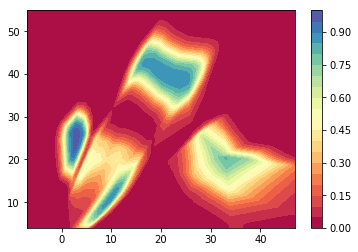

100%|██████████| 10000/10000 [01:13<00:00, 136.23it/s]


2/10 is done! Time is 73.41 seconds;


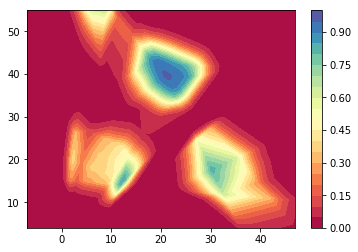

100%|██████████| 10000/10000 [01:13<00:00, 135.22it/s]


3/10 is done! Time is 73.96 seconds;


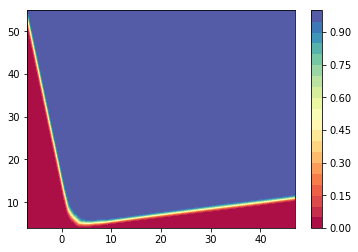

100%|██████████| 10000/10000 [01:13<00:00, 135.95it/s]


4/10 is done! Time is 73.56 seconds;


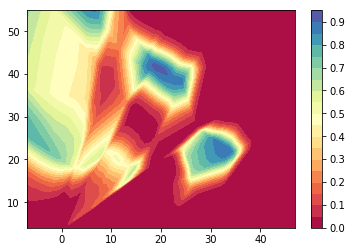

100%|██████████| 10000/10000 [01:13<00:00, 135.62it/s]


5/10 is done! Time is 73.74 seconds;


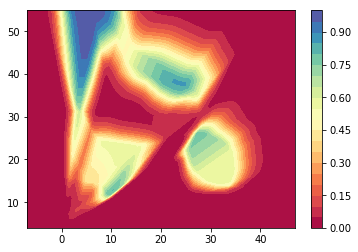

100%|██████████| 10000/10000 [01:13<00:00, 135.32it/s]


6/10 is done! Time is 73.90 seconds;


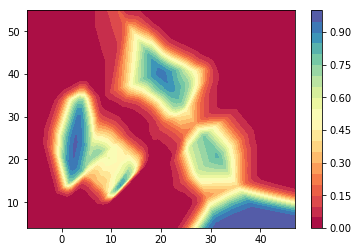

100%|██████████| 10000/10000 [01:13<00:00, 135.91it/s]


7/10 is done! Time is 73.58 seconds;


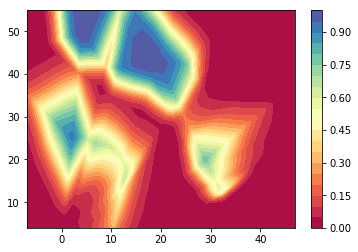

100%|██████████| 10000/10000 [01:13<00:00, 135.91it/s]


8/10 is done! Time is 73.58 seconds;


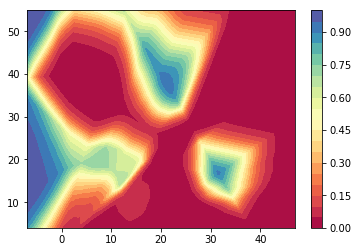

100%|██████████| 10000/10000 [01:14<00:00, 134.59it/s]


9/10 is done! Time is 74.30 seconds;


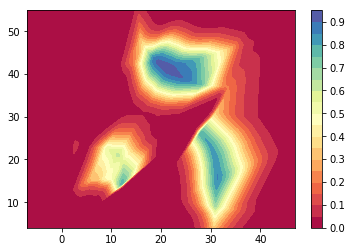

100%|██████████| 10000/10000 [01:15<00:00, 131.80it/s]


10/10 is done! Time is 75.87 seconds;


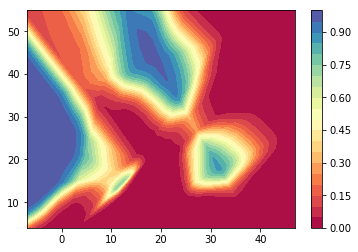

In [8]:
for iter in range(G_D_num):

    begin = time()

    D = Discriminator(ngpu).to(device)
    G = Generator(ngpu).to(device)

    # optimization
    opt_D = torch.optim.Adam(D.parameters(), lr=LR_D)
    opt_G = torch.optim.Adam(G.parameters(), lr=LR_G)

    plt.ion()

    for step in tqdm(range(10000)):

        for _ in range(critic_num):

            # random samples of real data
            idx = np.random.choice(len(data), BATCH_SIZE)
            selected_real = data[idx].float()

            # random noises
            G_noise = torch.randn(BATCH_SIZE, random_neuron).cuda()
            G_data = G(G_noise)

            prob_real = D(selected_real)  # D try to increase this prob
            prob_fake = D(G_data)  # D try to decrease this prob

            D_loss = -torch.mean(
                torch.log(prob_real + 1e-9) + torch.log(1. - prob_fake + 1e-9))
            G_loss = torch.mean(torch.log(1. - prob_fake + 1e-9))

#             D_loss_history.append(D_loss.item())
#             G_loss_history.append(G_loss.item())

            opt_D.zero_grad()
            D_loss.backward(retain_graph=True)  # reusing computational graph
            opt_D.step()

        opt_G.zero_grad()
        G_loss.backward()
        opt_G.step()

        if (step % 5000 == -1) & (step > 0):
            plt.cla()
            plt.plot(selected_real.cpu().numpy()[:, 0],
                     selected_real.cpu().numpy()[:, 1],
                     '.b',
                     label='Real')
            plt.plot(G_data.cpu().detach().numpy()[:, 0],
                     G_data.cpu().detach().numpy()[:, 1],
                     '.r',
                     label='Fake')
            plt.xlim(
                round(min(data.cpu().numpy()[:, 0])) - 1,
                round(max(data.cpu().numpy()[:, 0])) + 1)
            plt.ylim(
                round(min(data.cpu().numpy()[:, 1])) - 1,
                round(max(data.cpu().numpy()[:, 1])) + 1)

            plt.text(round(min(data.cpu().numpy()[:, 0])) - 1,
                     round(max(data.cpu().numpy()[:, 1])) + 1.5,
                     'D accuracy=%.2f (0.5 for D to converge)' %
                     prob_real.detach().cpu().numpy().mean(),
                     fontdict={'size': 13})
            plt.legend(loc='upper right', fontsize=10)

            # visualize the background
            x = np.arange(
                round(min(data.cpu().numpy()[:, 0])) - 1,
                round(max(data.cpu().numpy()[:, 0])) + 1, 0.1)
            y = np.arange(
                round(min(data.cpu().numpy()[:, 1])) - 1,
                round(max(data.cpu().numpy()[:, 1])) + 1, 0.1)
            xx, yy = np.meshgrid(x, y, sparse=True)

            a = xx + yy - yy
            b = xx + yy - xx
            mem = np.concatenate([
                a.reshape([a.shape[0], a.shape[1], 1]),
                b.reshape([a.shape[0], a.shape[1], 1])
            ],
                                 axis=2)

            z = D(torch.from_numpy(mem).float().cuda()).cpu().detach().numpy()
            h = plt.contourf(x,
                             y,
                             z.reshape(z.shape[0], z.shape[1]),
                             20,
                             cmap='Spectral')
            plt.colorbar()
            plt.show()

    end = time()
    print(
        str(iter + 1) + '/' + str(G_D_num) +
        ' is done! Time is {0:0.2f} seconds;'.format((end - begin)))

    plt.ioff()
    plt.show()

    # visualize the background
    x = np.arange(
        round(min(data.cpu().numpy()[:, 0])) - 10,
        round(max(data.cpu().numpy()[:, 0])) + 10, 0.1)
    y = np.arange(
        round(min(data.cpu().numpy()[:, 1])) - 10,
        round(max(data.cpu().numpy()[:, 1])) + 10, 0.1)
    xx, yy = np.meshgrid(x, y, sparse=True)

    a = xx + yy - yy
    b = xx + yy - xx
    mem = np.concatenate([
        a.reshape([a.shape[0], a.shape[1], 1]),
        b.reshape([a.shape[0], a.shape[1], 1])
    ],
                         axis=2)

    z = D(torch.from_numpy(mem).float().cuda()).cpu().detach().numpy()
#     plt.plot(selected_real.cpu().numpy()[:, 0],
#              selected_real.cpu().numpy()[:, 1],
#              '.b',
#              label='Real')
#     plt.plot(G_data.cpu().detach().numpy()[:, 0],
#          G_data.cpu().detach().numpy()[:, 1],
#          '.r',
#          label='Fake')
    h = plt.contourf(x,
                     y,
                     z.reshape(z.shape[0], z.shape[1]),
                     20,
                     cmap='Spectral')
    plt.colorbar()
    plt.show()

    z_avg = z_avg + z / G_D_num

    G_group['G' + str(iter)] = G
    D_group['D' + str(iter)] = D

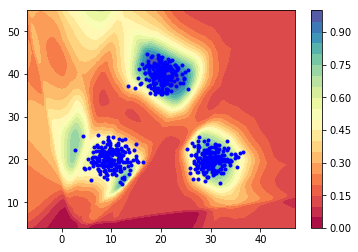

In [9]:
plt.plot(data.cpu().numpy()[:, 0], data.cpu().numpy()[:, 1], '.b', label='Real')
h = plt.contourf(x,
                 y,
                 (z_avg / np.max(z_avg)).reshape(z_avg.shape[0], z_avg.shape[1]),
                 20,
                 cmap='Spectral')
plt.colorbar()
plt.show()

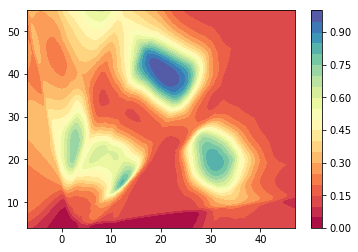

In [10]:
h = plt.contourf(x,
                 y,
                 (z_avg / np.max(z_avg)).reshape(z_avg.shape[0], z_avg.shape[1]),
                 20,
                 cmap='Spectral')
plt.colorbar()
plt.show()

---

# evaluation

In [11]:
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score

In [12]:
test = pd.read_csv('datasets/test/toy_test.csv', header=None)
test = test.values
label = test[:, 2]
label = label.reshape([-1, 1])
test = test[:, :2]
test = torch.tensor(test, device=device)

Precision score: 0.92
Recall score: 0.95
F1 score: 0.94


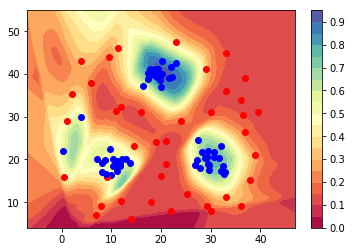

In [13]:
test_score = 0.0
for iter in range(G_D_num):
    prediction = D_group['D' + str(iter)](test.float()).cpu().detach().numpy()
    test_score = test_score + prediction / G_D_num

alpha = 0.5 * np.max(z_avg)
for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        test_score[i] = 0
    else:
        test_score[i] = 1

precision = average_precision_score(label, test_score)
recall = recall_score(label, test_score)
F1 = 2 * (precision * recall) / (precision + recall)
print('Precision score: {0:0.2f}'.format(precision))
print('Recall score: {0:0.2f}'.format(recall))
print('F1 score: {0:0.2f}'.format(F1))

h = plt.contourf(x,
                 y,
                 z_avg.reshape(z_avg.shape[0], z_avg.shape[1]),
                 20,
                 cmap='Spectral')
plt.colorbar()

for i in range(test_score.shape[0]):
    if test_score[i] > alpha:
        plt.plot(test.cpu().numpy()[i, 0],
                 test.cpu().numpy()[i, 1],
                 'or',
                 label='Test')
    else:
        plt.plot(test.cpu().numpy()[i, 0],
                 test.cpu().numpy()[i, 1],
                 'ob',
                 label='Test')

plt.show()

---

# trajectory 

In [14]:
traj_1 = pd.read_csv('datasets/test/toy_traj_1.csv', header=None)
traj_2 = pd.read_csv('datasets/test/toy_traj_2.csv', header=None)
traj_1 = traj_1.values
traj_2 = traj_2.values
traj_1 = torch.tensor(traj_1, device=device)
traj_2 = torch.tensor(traj_2, device=device)

In [15]:
traj_1_score = 0.0
traj_2_score = 0.0
for iter in range(G_D_num):
    prediction_1 = D_group['D' + str(iter)](traj_1.float()).cpu().detach().numpy()
    traj_1_score = traj_1_score + prediction_1 / G_D_num
    prediction_2 = D_group['D' + str(iter)](traj_2.float()).cpu().detach().numpy()
    traj_2_score = traj_2_score + prediction_2 / G_D_num

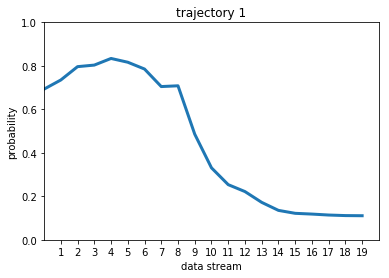

In [16]:
plt.plot(traj_1_score / np.max(z_avg), linewidth=3.0)
plt.xlim([0,len(traj_1)])
plt.ylim([0,1])
plt.xticks(range(1, 20))
plt.xlabel('data stream')
plt.ylabel('probability')
plt.title('trajectory 1')
plt.show()

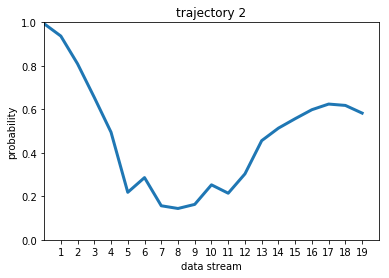

In [17]:
plt.plot(traj_2_score / np.max(z_avg), linewidth=3.0)
plt.xlim([0,len(traj_1)])
plt.ylim([0,1])
plt.xticks(range(1, 20))
plt.xlabel('data stream')
plt.ylabel('probability')
plt.title('trajectory 2')
plt.show()

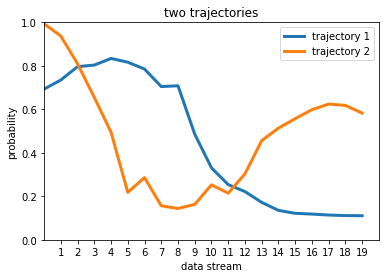

In [27]:
plt.plot(traj_1_score / np.max(z_avg), linewidth=3.0, label='trajectory 1')
plt.plot(traj_2_score / np.max(z_avg), linewidth=3.0, label='trajectory 2')
plt.xlim([0,len(traj_1)])
plt.ylim([0,1])
plt.xticks(range(1, 20))
plt.xlabel('data stream')
plt.ylabel('probability')
plt.title('two trajectories')
plt.legend(loc='upper right')
plt.show()